# Libraries Implemented

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Data Loading

In [ ]:
col_names=["tweet id","entity","sentiment","tweet content"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
col_names=["tweet id","entity","sentiment","tweet content"]
df = pd.read_csv("/content/drive/MyDrive/myskill/Salinan twitter_training.csv",names=col_names,header=None)
df.head()

,tweet id,entity,sentiment,tweet content


In [ ]:
df_val = pd.read_csv("/content/drive/MyDrive/myskill/Salinan twitter_validation.csv",names=col_names,header=None)
df_val.head()

,tweet id,entity,sentiment,tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


# Data Cleaning

**Remove null values**

In [ ]:
#Before remove
df.isnull().sum()

,0
tweet id,0
entity,0
sentiment,0
tweet content,0


In [ ]:
#After remove
df = df.dropna()
df.isnull().sum()

,0
tweet id,0
entity,0
sentiment,0
tweet content,0


**Remove duplicate values**

In [ ]:
#Before remove
df_duplicated = df.duplicated().sum()
print(f"There are {df_duplicated} duplicate values in the dataset")

There are 0 duplicate values in the dataset


In [ ]:
#After remove
df = df.drop_duplicates()
df_remove_duplicated = df.duplicated().sum()
print(f"There are {df_remove_duplicated} duplicate values in the dataset")

There are 0 duplicate values in the dataset


**Remove outliners**

[Text(0.5, 1.0, 'Distribution of tweet content length')]

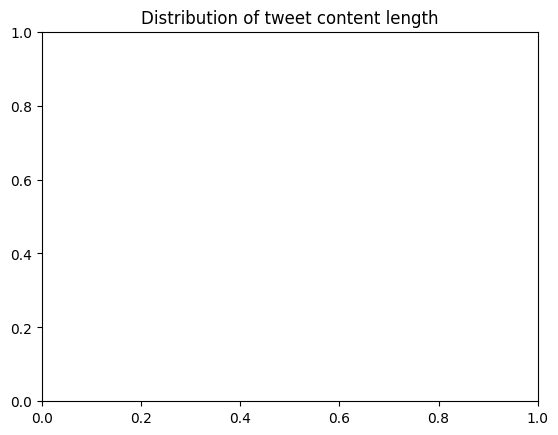

In [ ]:
#Identify outliners on tweet content length
df["tweet content length"] = df["tweet content"].map(lambda x:len(x.split(" ")))
sns.boxplot(x="tweet content length",data=df).set(title='Distribution of tweet content length')

In [ ]:
# Check if 'tweet content length' column is empty before calculating percentiles
if df["tweet content length"].empty:
    print("Warning: 'tweet content length' column is empty. Skipping outlier removal.")
    # Assign default values to lower_boundary and upper_boundary
    lower_boundary = float('-inf')  # Negative infinity to include all values
    upper_boundary = float('inf')   # Positive infinity to include all values
else:
    #Using Outlier Formula to remove rows
    lower_quartile = np.percentile(df["tweet content length"],25) #Calculating lower_quartile
    median = np.percentile(df["tweet content length"],50) #Calculating median
    upper_quartile = np.percentile(df["tweet content length"],75) #Calculating upper_quartile

    interquartile_range = upper_quartile - lower_quartile #Calculating interquartile_range(IQR)
    lower_boundary = lower_quartile - 1.5*interquartile_range #Calculating lower_boundary
    upper_boundary = upper_quartile + 1.5*interquartile_range #Calculating upper_boundary

    #tweet content length smaller than lower_boundary or larger than upper_boundary will be removed
    print("lower_boundary:",lower_boundary)
    print("upper_boundary:",upper_boundary)

    #Remove outliers
    removed_df = df[(df["tweet content length"]>=lower_boundary)&(df["tweet content length"]<=upper_boundary)]

In [ ]:
#
removed_df = df[(df["tweet content length"]>=lower_boundary)&(df["tweet content length"]<=upper_boundary)]

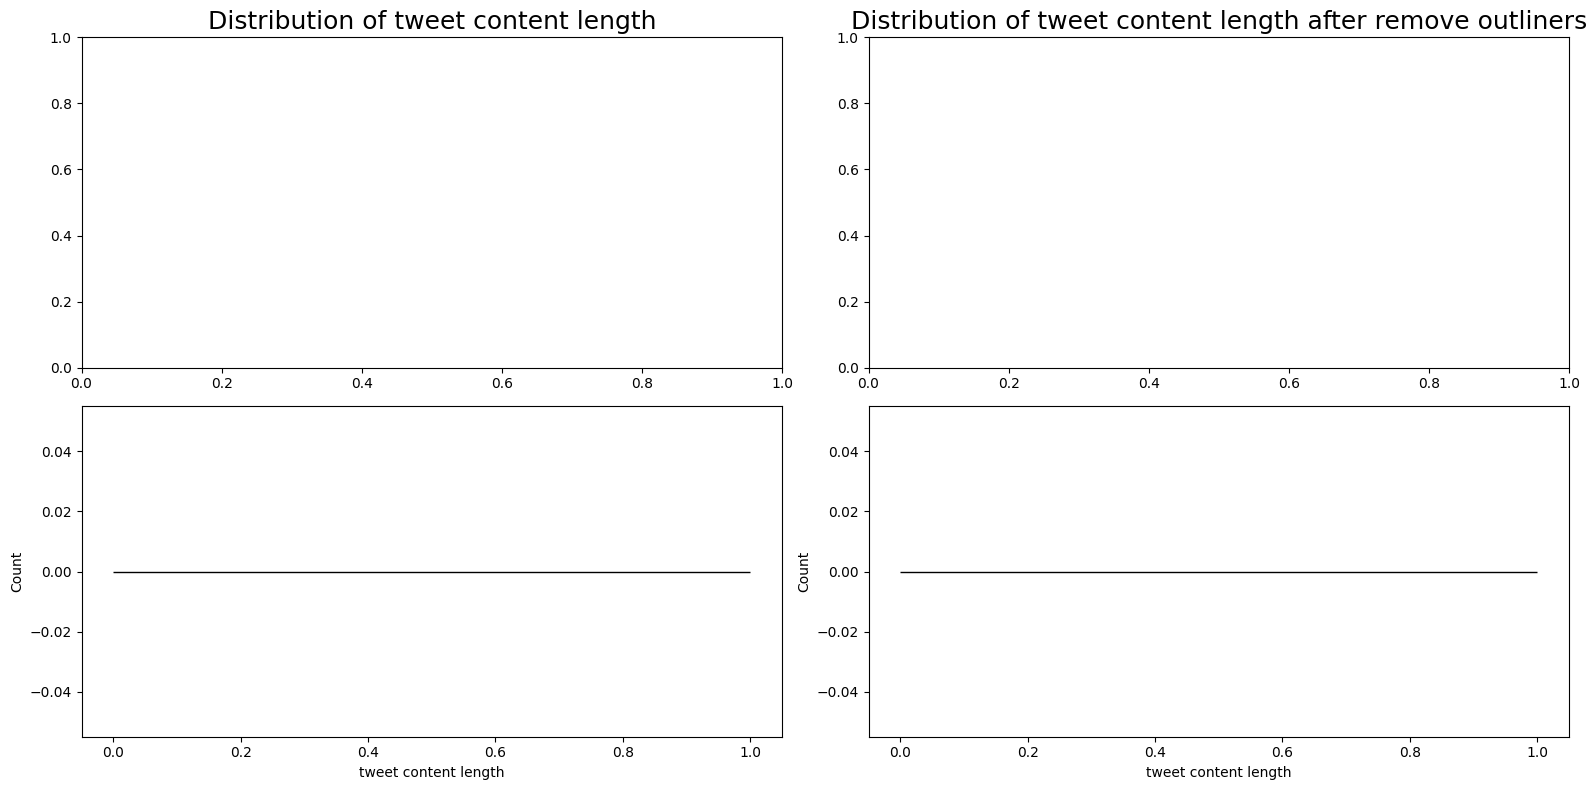

In [ ]:
#Compare the distribution of tweet content length before and after remove outliers

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))

#distribution of tweet content length
sns.boxplot(x="tweet content length",data=df,ax=ax[0,0]).set_title("Distribution of tweet content length",fontsize=18)
sns.boxplot(x="tweet content length",data=removed_df,ax=ax[0,1],color="orange").set_title("Distribution of tweet content length after remove outliners",fontsize=18)

#frequency of tweet content length
sns.histplot(x="tweet content length",data=df,ax=ax[1,0])
sns.histplot(x="tweet content length",data=removed_df,ax=ax[1,1],color="orange")

fig.tight_layout()

The tweet content length skewness is reduced after removing outliers, meaning that it has a more even distribution.

**Distribution of Labels after Data Cleaning**

<Axes: >

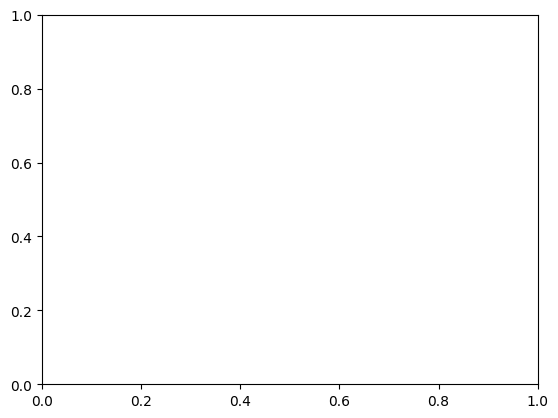

In [ ]:
sns.countplot(x="sentiment",data=removed_df)

Distribution of sentiment is balanced, therefore resampling is not required.

# Exploratory Data Analysis

**Frequency of words (wordcloud)**

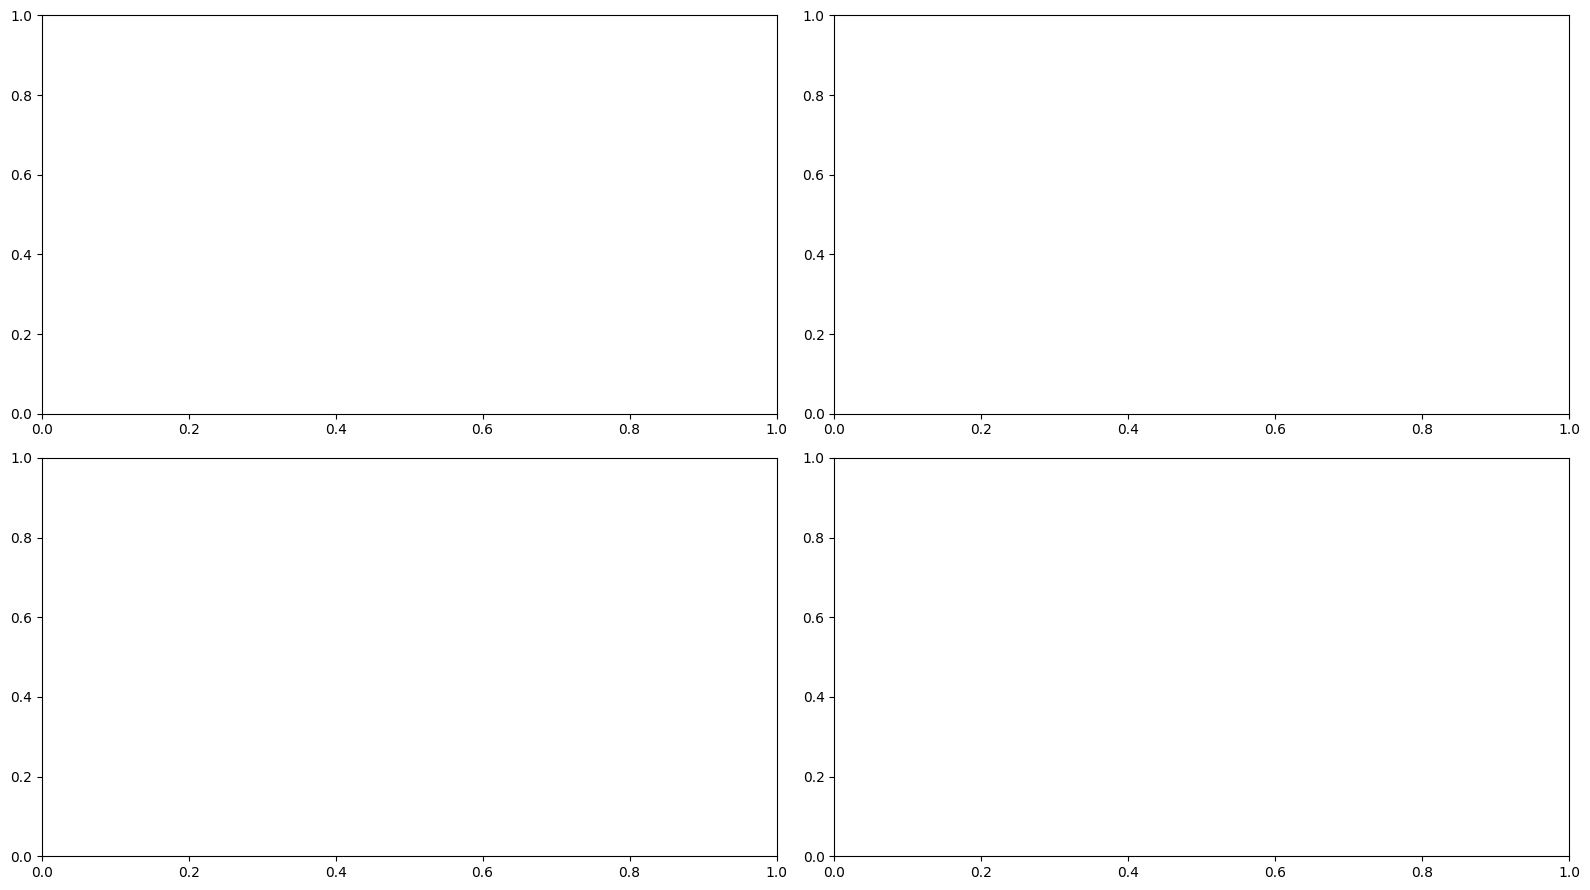

In [ ]:
sentiment_list=["Positive","Neutral","Negative","Irrelevant"]
colormap_list=["YlGn_r","Blues_r","Reds_r","copper_r"]
ax_list = [[0,0],[0,1],[1,0],[1,1]]
stopwords_set = set(STOPWORDS)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,9))
for sentiment,(row,col),colormap in zip(sentiment_list,ax_list,colormap_list):

    #Create wordcloud for each sentiment
    text = " ".join(content for content in removed_df[removed_df["sentiment"]==sentiment]["tweet content"])

    # Check if text is empty and skip if it is
    if not text:
        print(f"Warning: No text found for sentiment '{sentiment}'. Skipping wordcloud generation.")
        continue  # Skip to the next sentiment

    wordcloud = WordCloud(colormap=colormap, stopwords=stopwords_set, width=1600, height=900).generate(text)

    #Plot wordcloud
    ax[row,col].imshow(wordcloud)
    ax[row,col].set_title(sentiment+" wordcloud", fontsize=18)
    ax[row,col].axis('off')

fig.tight_layout()

**Frequency of entity**

Text(0.5, 1.0, 'Frequency of entity')

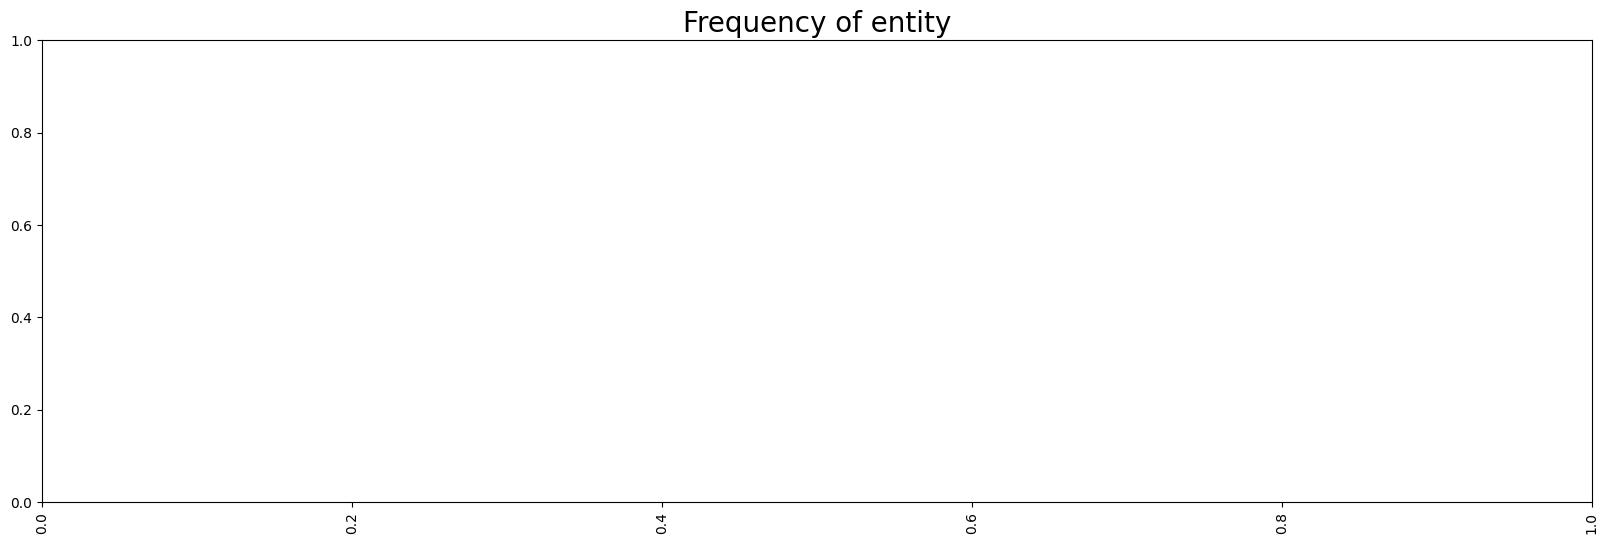

In [ ]:
entity_frequency = removed_df.groupby(["sentiment","entity"]).size().reset_index()
entity_frequency.rename(columns={0: 'frequency'}, inplace=True)

plt.figure(figsize=(20,6))
plt.xticks(rotation=90)
sns.barplot(data=entity_frequency,x="entity",y="frequency",hue="sentiment").set_title("Frequency of entity", fontsize=20)

# Data Splitting

In [ ]:
#Split the training and validation dataset into x_train, y_train, x_test and y_test
x_train = df["entity"] + " " + df["tweet content"]
y_train = df["sentiment"]
x_test = df_val["entity"] + " " + df_val["tweet content"]
y_test = df_val["sentiment"]

In [ ]:
x_train.head()

,0


# Text Preprocessing

In [ ]:
# function turns pos_tag into wordnet_pos
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
def text_preprocessing(text):

    #tokenize
    text_tokenize = word_tokenize(text)

    #split text and entity
    entity = text_tokenize[0]
    text_content = text_tokenize[1:]

    #pos tagging
    text_pos = pos_tag(text_content)

    #remove punctuation and stopwords
    remove_words = set(list(string.punctuation) + stopwords.words('english'))
    text_remove = [(word,pos) for (word,pos) in text_pos if word not in remove_words]

    #lemmaization
    word_lem = WordNetLemmatizer()
    text_lem = [(word_lem.lemmatize(word,pos=get_wordnet_pos(pos)),pos) if get_wordnet_pos(pos) != None
                 else (word_lem.lemmatize(word),pos) for (word,pos) in text_remove]

    #combine text and entity
    text_lem.append((entity,))

    return text_lem

In [ ]:
#test text_preprocessing
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') # Download the averaged_perceptron_tagger
nltk.download('punkt_tab') # Download the missing 'punkt_tab' data package

example_text = "Overwatch Overwatch is a wonderful game, even after so many years."
print("Original sentence: ", example_text)
print("After text_preprocessing: ", text_preprocessing(example_text))

Original sentence:  Overwatch Overwatch is a wonderful game, even after so many years.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93maveraged_perceptron_tagger_eng[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtaggers/averaged_perceptron_tagger_eng/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
#Combine text_preprocessing, CountVectorizer and TfidfTransformer into pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_preprocessing)),
    ('tfidf', TfidfTransformer())
])

#Apply pipeline to x_train and x_test
x_train_processed = pipeline.fit_transform(x_train)
x_test_processed = pipeline.transform(x_test)

ValueError: empty vocabulary; perhaps the documents only contain stop words

# Models

In [ ]:
classifier_used = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
]

In [ ]:
classifier_accuracy=[]

for classifier in classifier_used:

    fit = classifier.fit(x_train_processed, y_train)
    predict = fit.predict(x_test_processed)
    trainset_predict = fit.predict(x_train_processed)

    accuracy = accuracy_score(predict,y_test)
    trainset_accuracy = accuracy_score(trainset_predict,y_train)

    classifier_accuracy.append([classifier.__class__.__name__,accuracy,trainset_accuracy])

In [ ]:
classifier_result = pd.DataFrame(classifier_accuracy,columns=["classifier","accuracy","accuracy on trainset"]).sort_values(by='accuracy',ascending=False)
classifier_result

**The KNeighborsClassifier obtains the highest accuracy of 0.992.**